# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band12.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.165403 -0.205384  0.214381 -0.153429  0.171289  0.479515   
      201547 -0.443524  0.190086 -0.010577 -0.140588 -0.264274 -0.319112   
      201548  0.068206 -0.315688 -0.123277  0.256323  0.142908 -0.019935   
      201549 -0.098526  0.699316 -0.112922  0.281156  0.139299  0.109401   
      201550 -0.066115 -0.336867  0.472051  0.242660 -0.110244  0.195084   

                     6         7         8         9  ...      1015      1016  \
41001 201546  0.165239  0.655906 -0.169964  0.261811  ... -0.217888 -0.428662   
      201547  0.244517 -0.112073 -0.140217  0.066699  ... -0.048172 -0.087228   
      201548  0.214275  0.184410  0.236449  0.266294  ... -0.340213  0.497039   
      201549  0.192370 -0.398097 -0.155751  0.339677  ...  0.421744 -0.109359   
      201550 -0.292043 -0.758299  0.092613  0.018923  ...  0.105434  0.262742   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.057681 -0.364758 -0.244590 -0.092992 -0.148963 -0.004574   
      201547 -0.017862  0.589471  0.565704 -0.099681 -0.240630  0.195278   
      201548 -0.212558 -0.185764  0.579054 -0.145058  0.271871 -0.369211   
      201549 -0.239127  0.214297 -0.096080  0.478322  0.418887  0.150039   
      201550  0.153415 -0.148262  0.056952  0.245845 -0.025773  0.236105   

                  1023    Labels  
41001 201546  0.477046 -0.861740  
      201547 -0.030118 -0.854589  
      201548 -0.032847 -0.856973  
      201549  0.612831 -0.856973  
      201550  0.189671 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -0.313725 -0.029987 -0.495105 -0.005148 -0.076804 -0.112575   
      201821  0.147466  0.397743 -0.276024 -0.241289 -0.357491  0.122545   
      201822  0.457491  0.292494  0.072201  0.303927 -0.079993  0.348360   
      201823  0.151711 -0.061627  0.098463  0.048547  0.159984  0.180242   
      201824  0.121903  0.004382  0.123883 -0.068798  0.080533 -0.259029   

                     6         7         8         9  ...      1015      1016  \
41001 201820  0.176699  0.692627  0.287324  0.521769  ... -0.230961  0.499516   
      201821  0.279847 -0.364001  0.689226  0.192611  ...  0.394962  0.249294   
      201822  0.064192  0.383997 -0.171165 -0.221596  ... -0.186987 -0.140864   
      201823 -0.030101  0.469325  0.041577  0.295836  ...  0.373554 -0.097207   
      201824  0.011483 -0.164209  0.162787  0.290558  ...  0.122113  0.071327   

                  1017      1018      1019      1020      1021      1022  \
41001 201820 -0.191957 -0.246249 -0.411743 -0.690742  0.658670  0.119215   
      201821 -0.067712  0.192896  0.120958  0.481591  0.296620 -0.108778   
      201822 -0.506690  0.122173 -0.295356 -0.009781  0.643750  0.242826   
      201823 -0.001175  0.061497  0.032487  0.034638  0.451365  0.056550   
      201824  0.049809 -0.028478  0.135323  0.270672 -0.013897  0.104492   

                  1023    Labels  
41001 201820  0.617611 -0.949940  
      201821  0.065553 -0.961859  
      201822  0.142820 -0.940405  
      201823 -0.255891 -0.961859  
      201824 -0.179143 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

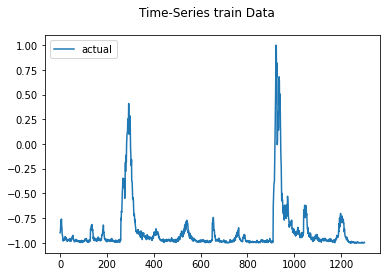

2023-03-14 15:37:14.155829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 15:37:14.155916: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 15:37:14.155958: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 15:37:14.156221: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 15:37:14.292285: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 57.302
Test RMSE: 66.988
Test sMAPE: 109.356
Test R Squared: -3.643
{'mae': 57.301724909291124, 'rmse': 66.98848847759818, 'smape': 109.3561185241829, 'r2': -3.6434669490303486}


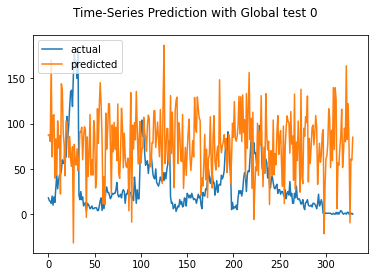

Test MAE: 60.805
Test RMSE: 69.200
Test sMAPE: 112.339
Test R Squared: -3.955
{'mae': 60.80543603391359, 'rmse': 69.20009672850972, 'smape': 112.33931473227435, 'r2': -3.955134014170193}


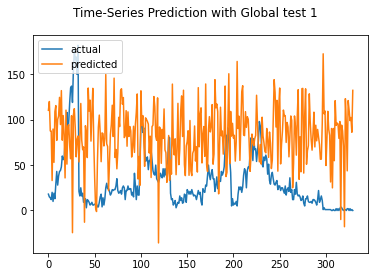

Test MAE: 73.644
Test RMSE: 80.386
Test sMAPE: 119.814
Test R Squared: -5.687
{'mae': 73.64403654589798, 'rmse': 80.38642180126695, 'smape': 119.81391276118511, 'r2': -5.686631606167132}


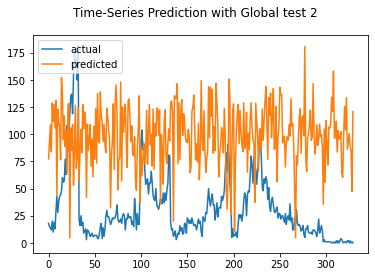

Test MAE: 41.795
Test RMSE: 50.041
Test sMAPE: 99.827
Test R Squared: -1.591
{'mae': 41.794734712803006, 'rmse': 50.040983763531514, 'smape': 99.82719399834976, 'r2': -1.5911567113118004}


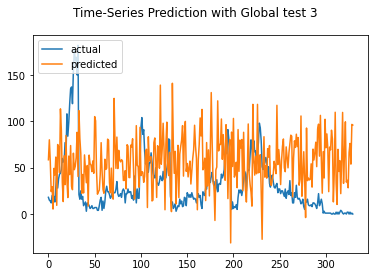

Test MAE: 55.339
Test RMSE: 63.976
Test sMAPE: 107.151
Test R Squared: -3.235
{'mae': 55.33948056336605, 'rmse': 63.97624994161521, 'smape': 107.1505606194111, 'r2': -3.235254973076289}


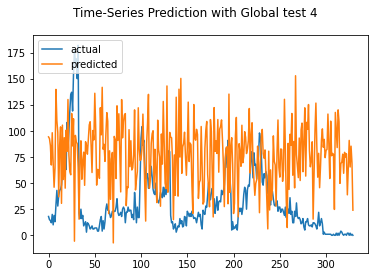

Test MAE: 40.323
Test RMSE: 49.253
Test sMAPE: 102.165
Test R Squared: -1.510
{'mae': 40.32325470375292, 'rmse': 49.25309213949025, 'smape': 102.16477701697636, 'r2': -1.510203920850476}


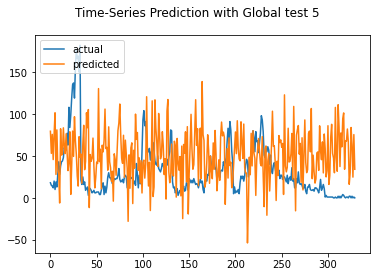

Test MAE: 58.354
Test RMSE: 66.268
Test sMAPE: 111.047
Test R Squared: -3.544
{'mae': 58.35409244190563, 'rmse': 66.2684010011624, 'smape': 111.04662211018343, 'r2': -3.5441743380117074}


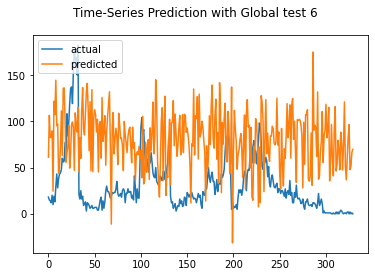

Test MAE: 39.870
Test RMSE: 52.001
Test sMAPE: 110.315
Test R Squared: -1.798
{'mae': 39.86984976421703, 'rmse': 52.000596766229705, 'smape': 110.3152182848857, 'r2': -1.7980705276537376}


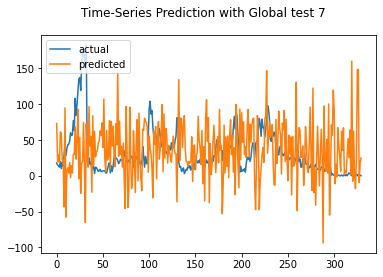

Test MAE: 39.032
Test RMSE: 49.752
Test sMAPE: 99.630
Test R Squared: -1.561
{'mae': 39.0317747018554, 'rmse': 49.75223099826714, 'smape': 99.63033355428294, 'r2': -1.561339352812214}


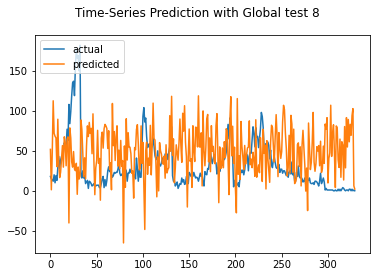

Test MAE: 49.255
Test RMSE: 57.844
Test sMAPE: 109.322
Test R Squared: -2.462
{'mae': 49.25545327844042, 'rmse': 57.8444028133592, 'smape': 109.32242951433524, 'r2': -2.4622999159354078}


Test MAE: 46.745
Test RMSE: 55.048
Test sMAPE: 103.253
Test R Squared: -2.136
{'mae': 46.744650318405846, 'rmse': 55.04785357715954, 'smape': 103.25322694767657, 'r2': -2.135615343896152}


Test MAE: 56.132
Test RMSE: 65.485
Test sMAPE: 108.859
Test R Squared: -3.437
{'mae': 56.13163022994995, 'rmse': 65.48495019584948, 'smape': 108.85938871305953, 'r2': -3.437363480080198}


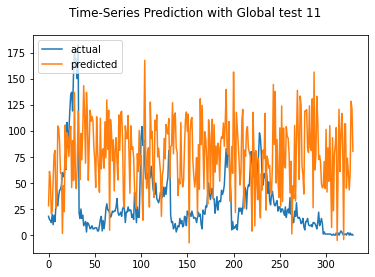

Test MAE: 46.191
Test RMSE: 54.851
Test sMAPE: 103.175
Test R Squared: -2.113
{'mae': 46.1906523903211, 'rmse': 54.85066149774725, 'smape': 103.17473093389805, 'r2': -2.113190816819154}


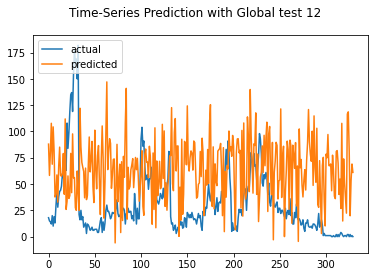

Test MAE: 52.944
Test RMSE: 61.893
Test sMAPE: 105.212
Test R Squared: -2.964
{'mae': 52.9441442417376, 'rmse': 61.89274169806241, 'smape': 105.21192647453638, 'r2': -2.9638886327339793}


Test MAE: 43.879
Test RMSE: 52.296
Test sMAPE: 100.153
Test R Squared: -1.830
{'mae': 43.878566900708456, 'rmse': 52.29640269377274, 'smape': 100.15347442026548, 'r2': -1.8299947765698787}


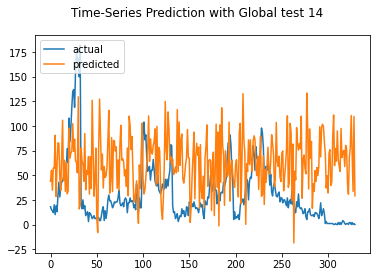

Test MAE: 45.395
Test RMSE: 53.806
Test sMAPE: 100.925
Test R Squared: -1.996
{'mae': 45.39548874027801, 'rmse': 53.80565787685889, 'smape': 100.92541192666557, 'r2': -1.9956970610428089}


Test MAE: 59.222
Test RMSE: 67.411
Test sMAPE: 109.813
Test R Squared: -3.702
{'mae': 59.22151146224051, 'rmse': 67.4110844391423, 'smape': 109.81338084778538, 'r2': -3.7022382403083443}


Test MAE: 41.204
Test RMSE: 48.831
Test sMAPE: 99.309
Test R Squared: -1.467
{'mae': 41.20366756338062, 'rmse': 48.83097903813158, 'smape': 99.30881191317827, 'r2': -1.4673619622416223}


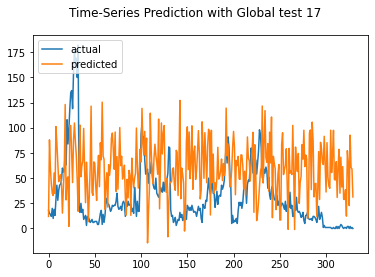

Test MAE: 52.254
Test RMSE: 59.699
Test sMAPE: 104.264
Test R Squared: -2.688
{'mae': 52.254139600378096, 'rmse': 59.69949229224153, 'smape': 104.263858247893, 'r2': -2.6879351625605707}


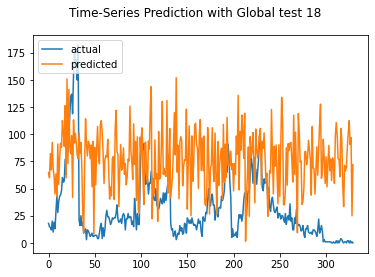

Test MAE: 59.429
Test RMSE: 70.059
Test sMAPE: 108.920
Test R Squared: -4.079
{'mae': 59.429444859967084, 'rmse': 70.05893510672317, 'smape': 108.92021224105625, 'r2': -4.078893021248472}


Test MAE: 51.703
Test RMSE: 61.202
Test sMAPE: 104.015
Test R Squared: -2.876
{'mae': 51.70311329653769, 'rmse': 61.20176075788964, 'smape': 104.01450943365354, 'r2': -2.8758756525012465}


Test MAE: 59.751
Test RMSE: 69.592
Test sMAPE: 109.625
Test R Squared: -4.011
{'mae': 59.75080634012367, 'rmse': 69.59192039407904, 'smape': 109.62527103909964, 'r2': -4.011406636306435}


Test MAE: 48.979
Test RMSE: 59.984
Test sMAPE: 106.518
Test R Squared: -2.723
{'mae': 48.97889830343651, 'rmse': 59.98441082048341, 'smape': 106.51841272797654, 'r2': -2.723220838222975}


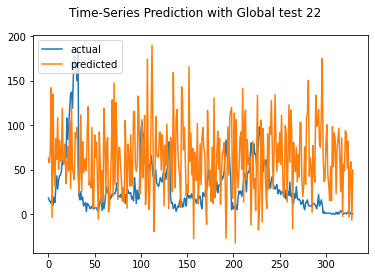

Test MAE: 51.033
Test RMSE: 60.783
Test sMAPE: 108.434
Test R Squared: -2.823
{'mae': 51.033270515095104, 'rmse': 60.78281096158002, 'smape': 108.43402679928607, 'r2': -2.822993528398901}


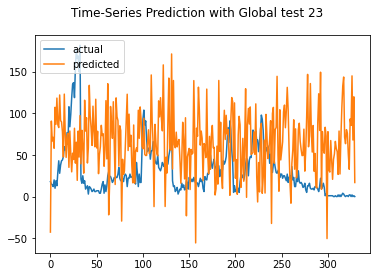

Test MAE: 52.617
Test RMSE: 60.849
Test sMAPE: 107.941
Test R Squared: -2.831
{'mae': 52.617142700245886, 'rmse': 60.848656127090976, 'smape': 107.94110665565826, 'r2': -2.8312808051163323}


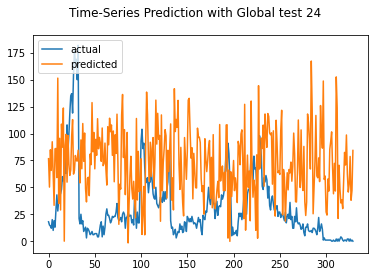

Test MAE: 35.559
Test RMSE: 44.408
Test sMAPE: 99.258
Test R Squared: -1.041
{'mae': 35.55885657650052, 'rmse': 44.407580573218446, 'smape': 99.25757960578456, 'r2': -1.0405922202931692}


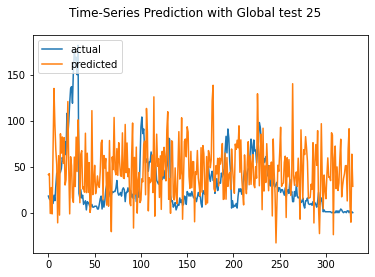

Test MAE: 39.707
Test RMSE: 49.132
Test sMAPE: 102.265
Test R Squared: -1.498
{'mae': 39.70678246599255, 'rmse': 49.13214201747852, 'smape': 102.26547214584858, 'r2': -1.4978905138099479}


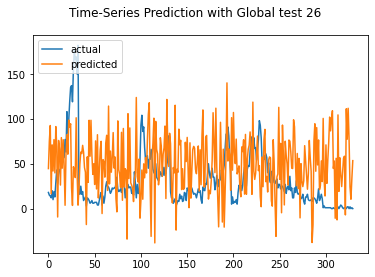

Test MAE: 65.264
Test RMSE: 74.429
Test sMAPE: 112.831
Test R Squared: -4.732
{'mae': 65.26392466660702, 'rmse': 74.42937262425797, 'smape': 112.83063244934068, 'r2': -4.73232385204183}


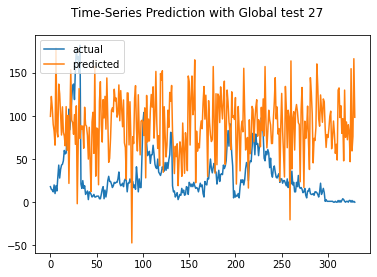

Test MAE: 51.035
Test RMSE: 60.687
Test sMAPE: 103.871
Test R Squared: -2.811
{'mae': 51.03456247755975, 'rmse': 60.68677414718569, 'smape': 103.8706188604025, 'r2': -2.8109224159517963}


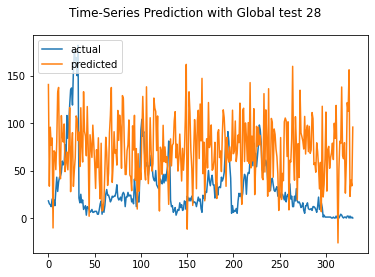

Test MAE: 55.402
Test RMSE: 64.273
Test sMAPE: 108.556
Test R Squared: -3.275
{'mae': 55.402217799244504, 'rmse': 64.27290671230912, 'smape': 108.55626417669016, 'r2': -3.2746236468164582}


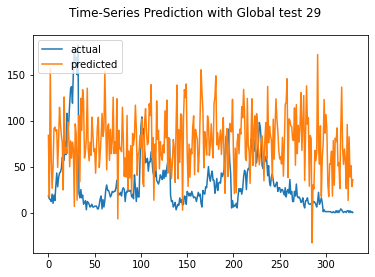

Test MAE: 37.668
Test RMSE: 46.736
Test sMAPE: 100.736
Test R Squared: -1.260
{'mae': 37.667907604846086, 'rmse': 46.7360532637445, 'smape': 100.73623056054902, 'r2': -1.260195837824165}


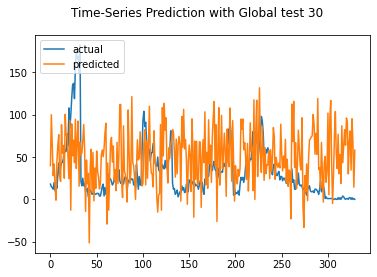

Test MAE: 67.011
Test RMSE: 76.696
Test sMAPE: 113.373
Test R Squared: -5.087
{'mae': 67.01144402966355, 'rmse': 76.69553277176097, 'smape': 113.37318948600515, 'r2': -5.086703393188586}


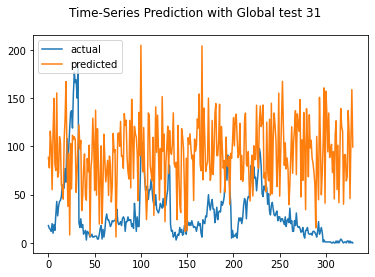

Test MAE: 46.709
Test RMSE: 55.604
Test sMAPE: 102.247
Test R Squared: -2.199
{'mae': 46.708876545230545, 'rmse': 55.60388391573723, 'smape': 102.24735920873209, 'r2': -2.199280048446602}


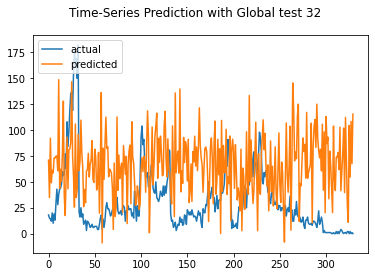

Test MAE: 44.016
Test RMSE: 52.260
Test sMAPE: 98.878
Test R Squared: -1.826
{'mae': 44.01572296185927, 'rmse': 52.260109207028314, 'smape': 98.87782022172584, 'r2': -1.8260681302870299}


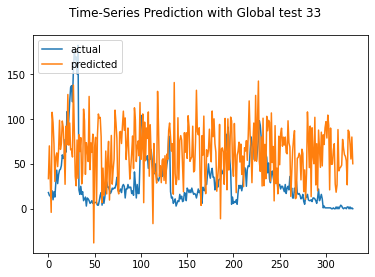

Test MAE: 50.331
Test RMSE: 59.635
Test sMAPE: 105.856
Test R Squared: -2.680
{'mae': 50.33138141487584, 'rmse': 59.63464451848122, 'smape': 105.85563026977911, 'r2': -2.6799275736594517}


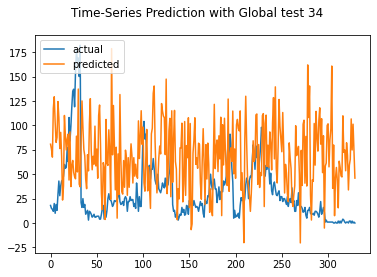

Test MAE: 37.548
Test RMSE: 46.302
Test sMAPE: 101.919
Test R Squared: -1.218
{'mae': 37.547531964200914, 'rmse': 46.30155684988346, 'smape': 101.91851334965556, 'r2': -1.2183659457555471}


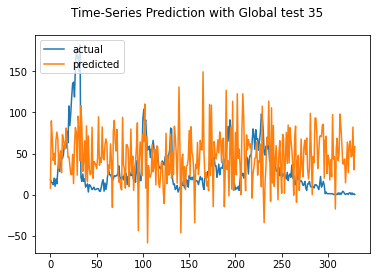

Test MAE: 46.683
Test RMSE: 55.259
Test sMAPE: 100.644
Test R Squared: -2.160
{'mae': 46.68292982722774, 'rmse': 55.25850577247526, 'smape': 100.64379698066173, 'r2': -2.1596594448149506}


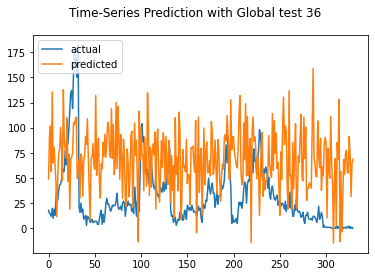

Test MAE: 49.879
Test RMSE: 59.805
Test sMAPE: 104.376
Test R Squared: -2.701
{'mae': 49.87925592462222, 'rmse': 59.80530328962129, 'smape': 104.37618961592467, 'r2': -2.701019693037147}


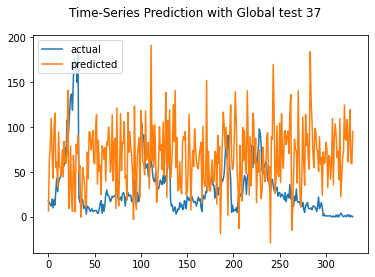

Test MAE: 58.004
Test RMSE: 66.629
Test sMAPE: 109.145
Test R Squared: -3.594
{'mae': 58.003664541966984, 'rmse': 66.62874761891399, 'smape': 109.14528566271174, 'r2': -3.593728269353237}


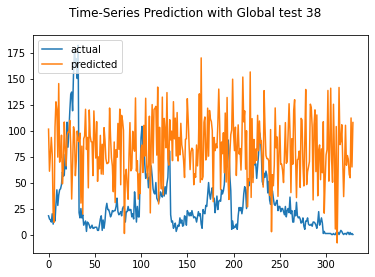

Test MAE: 47.866
Test RMSE: 57.086
Test sMAPE: 106.382
Test R Squared: -2.372
{'mae': 47.866210627465534, 'rmse': 57.085719592926885, 'smape': 106.38176102155525, 'r2': -2.3720729507600806}


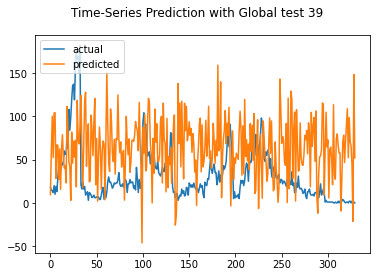

Test MAE: 46.058
Test RMSE: 55.018
Test sMAPE: 102.763
Test R Squared: -2.132
{'mae': 46.0584909511335, 'rmse': 55.01762784785385, 'smape': 102.76271924983823, 'r2': -2.1321728757702103}


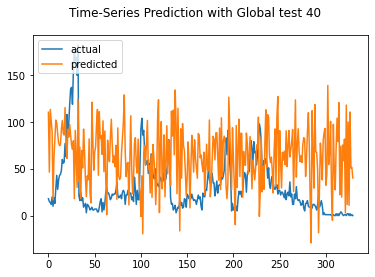

Test MAE: 69.965
Test RMSE: 77.860
Test sMAPE: 116.681
Test R Squared: -5.273
{'mae': 69.96532545378714, 'rmse': 77.85990242331985, 'smape': 116.68065910058367, 'r2': -5.272919465127373}


Test MAE: 53.383
Test RMSE: 62.863
Test sMAPE: 107.035
Test R Squared: -3.089
{'mae': 53.38316412116542, 'rmse': 62.8625906926977, 'smape': 107.03502076868575, 'r2': -3.089088895179991}


Test MAE: 59.650
Test RMSE: 67.243
Test sMAPE: 111.992
Test R Squared: -3.679
{'mae': 59.65042607134039, 'rmse': 67.24310373121415, 'smape': 111.99153165968048, 'r2': -3.678832559681184}


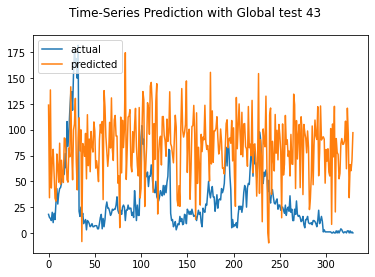

Test MAE: 40.235
Test RMSE: 48.542
Test sMAPE: 98.972
Test R Squared: -1.438
{'mae': 40.23490157723427, 'rmse': 48.54178899184883, 'smape': 98.97219570439786, 'r2': -1.4382237529515858}


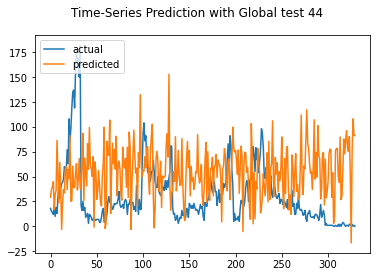

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 39.665
Test RMSE: 52.028
Test sMAPE: 107.364
Test R Squared: -1.801
{'mae': 39.665102676189306, 'rmse': 52.028249333594225, 'smape': 107.36411555538842, 'r2': -1.8010472014331782}


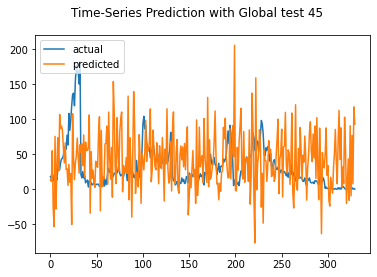

Test MAE: 35.850
Test RMSE: 44.368
Test sMAPE: 103.085
Test R Squared: -1.037
{'mae': 35.85000219616023, 'rmse': 44.36778419907549, 'smape': 103.08545651721899, 'r2': -1.036936457804126}


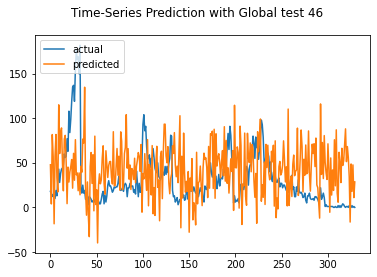

Test MAE: 62.491
Test RMSE: 69.931
Test sMAPE: 113.460
Test R Squared: -4.060
{'mae': 62.4911698659261, 'rmse': 69.93137289139128, 'smape': 113.46006302000806, 'r2': -4.060414720827947}


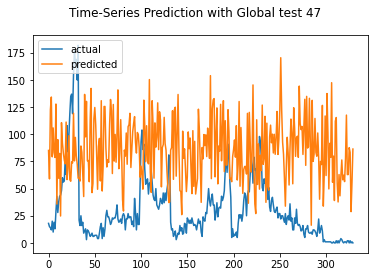

Test MAE: 81.294
Test RMSE: 88.958
Test sMAPE: 122.813
Test R Squared: -7.189
{'mae': 81.29422064116507, 'rmse': 88.95804342587218, 'smape': 122.8129872368885, 'r2': -7.188652591538766}


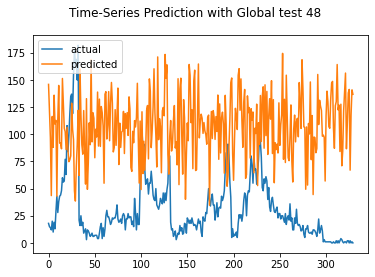

Test MAE: 42.077
Test RMSE: 50.979
Test sMAPE: 100.753
Test R Squared: -1.689
{'mae': 42.076696967897995, 'rmse': 50.97867907656515, 'smape': 100.75337485058344, 'r2': -1.689175574565272}


Test MAE: 47.521
Test RMSE: 57.103
Test sMAPE: 104.747
Test R Squared: -2.374
{'mae': 47.520747730948706, 'rmse': 57.1026116674826, 'smape': 104.74658325137304, 'r2': -2.37406888724745}


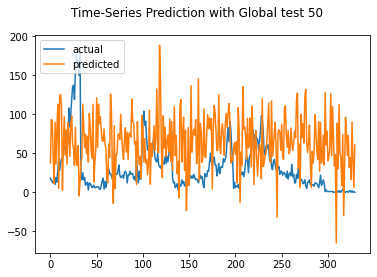

Test MAE: 54.930
Test RMSE: 63.211
Test sMAPE: 107.177
Test R Squared: -3.135
{'mae': 54.930332159996034, 'rmse': 63.21087717372859, 'smape': 107.17679623140992, 'r2': -3.134525128186822}


Test MAE: 48.085
Test RMSE: 59.141
Test sMAPE: 104.627
Test R Squared: -2.619
{'mae': 48.08495966629548, 'rmse': 59.14129607151955, 'smape': 104.62674206601426, 'r2': -2.6192924531062176}


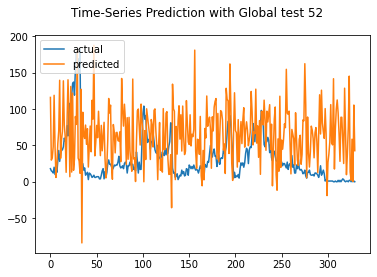

Test MAE: 41.350
Test RMSE: 50.446
Test sMAPE: 99.797
Test R Squared: -1.633
{'mae': 41.34952145273035, 'rmse': 50.4462257236494, 'smape': 99.79663084478291, 'r2': -1.6332940589411717}


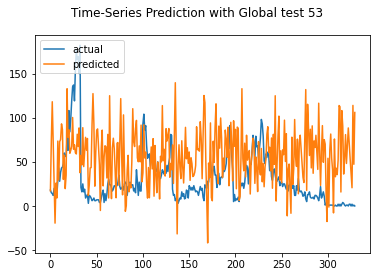

Test MAE: 49.113
Test RMSE: 58.145
Test sMAPE: 104.641
Test R Squared: -2.498
{'mae': 49.11268861944025, 'rmse': 58.14511528057625, 'smape': 104.6414475624181, 'r2': -2.4983920182280515}


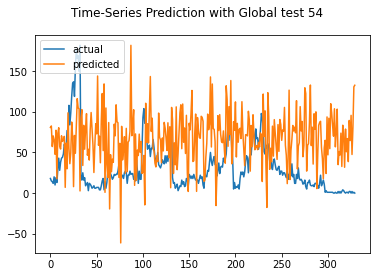

Test MAE: 50.198
Test RMSE: 59.072
Test sMAPE: 103.558
Test R Squared: -2.611
{'mae': 50.19774704990965, 'rmse': 59.07196120784775, 'smape': 103.55776811052667, 'r2': -2.6108112033641833}


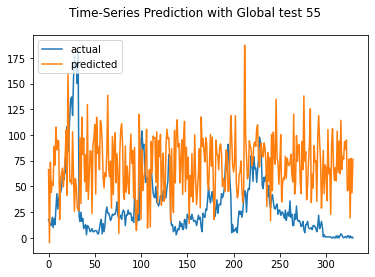

Test MAE: 36.111
Test RMSE: 45.232
Test sMAPE: 102.029
Test R Squared: -1.117
{'mae': 36.11136127656157, 'rmse': 45.23207982563677, 'smape': 102.02857429306572, 'r2': -1.1170695068134688}


Test MAE: 37.310
Test RMSE: 46.278
Test sMAPE: 103.726
Test R Squared: -1.216
{'mae': 37.31047699379199, 'rmse': 46.27755054979853, 'smape': 103.7260229993414, 'r2': -1.216066197905755}


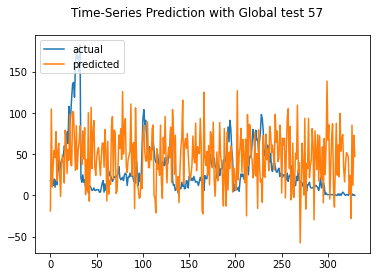

Test MAE: 31.143
Test RMSE: 41.455
Test sMAPE: 98.786
Test R Squared: -0.778
{'mae': 31.142601027542895, 'rmse': 41.454564271996034, 'smape': 98.78635909366143, 'r2': -0.7782249970193365}


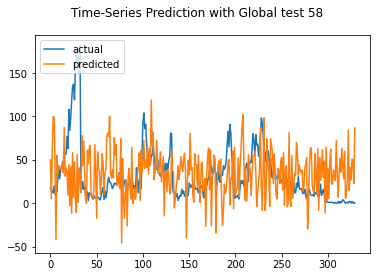

Test MAE: 61.702
Test RMSE: 72.064
Test sMAPE: 110.253
Test R Squared: -4.374
{'mae': 61.702494910269074, 'rmse': 72.06447877803369, 'smape': 110.25256162314574, 'r2': -4.373837150357259}


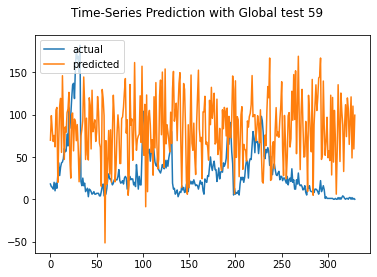

Test MAE: 33.430
Test RMSE: 42.650
Test sMAPE: 93.385
Test R Squared: -0.882
{'mae': 33.430303159988284, 'rmse': 42.649583719644184, 'smape': 93.38532855044987, 'r2': -0.882225248696785}


Test MAE: 58.613
Test RMSE: 68.086
Test sMAPE: 108.492
Test R Squared: -3.797
{'mae': 58.61273978840221, 'rmse': 68.0857755094044, 'smape': 108.49188468313726, 'r2': -3.796834985689519}


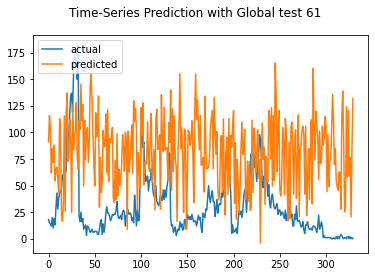

Test MAE: 50.088
Test RMSE: 62.123
Test sMAPE: 110.538
Test R Squared: -2.993
{'mae': 50.08817885283268, 'rmse': 62.12298859218533, 'smape': 110.537713153695, 'r2': -2.993435575932166}


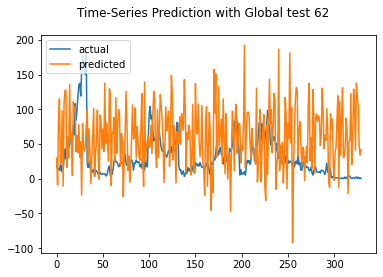

Test MAE: 63.405
Test RMSE: 73.208
Test sMAPE: 112.604
Test R Squared: -4.546
{'mae': 63.40486950928515, 'rmse': 73.20797245562186, 'smape': 112.604275971565, 'r2': -4.545730483902027}


Test MAE: 37.983
Test RMSE: 46.891
Test sMAPE: 99.246
Test R Squared: -1.275
{'mae': 37.98297410589276, 'rmse': 46.89078151144472, 'smape': 99.24573818927485, 'r2': -1.2751861939450087}


Test MAE: 71.340
Test RMSE: 79.929
Test sMAPE: 117.123
Test R Squared: -5.611
{'mae': 71.33971061742668, 'rmse': 79.92889382813107, 'smape': 117.12325521456879, 'r2': -5.610732848389355}


Test MAE: 40.658
Test RMSE: 49.365
Test sMAPE: 98.619
Test R Squared: -1.522
{'mae': 40.65816770557201, 'rmse': 49.365108054239236, 'smape': 98.61897563150937, 'r2': -1.5216347781655934}


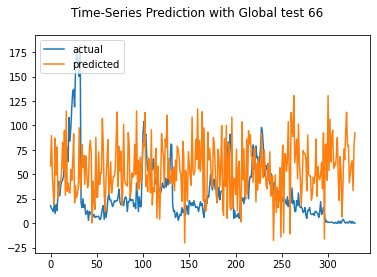

Test MAE: 60.144
Test RMSE: 69.289
Test sMAPE: 111.758
Test R Squared: -3.968
{'mae': 60.144468293045506, 'rmse': 69.28930307552318, 'smape': 111.75764690917556, 'r2': -3.9679176470532074}


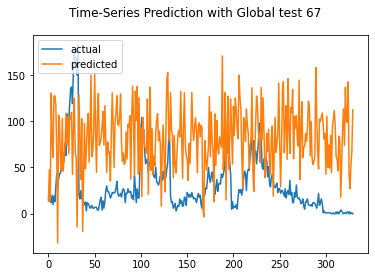

Test MAE: 44.089
Test RMSE: 52.576
Test sMAPE: 104.564
Test R Squared: -1.860
{'mae': 44.08866864316391, 'rmse': 52.57580865259079, 'smape': 104.56359450013754, 'r2': -1.8603153975294635}


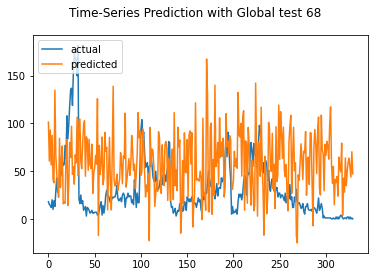

Test MAE: 38.718
Test RMSE: 47.550
Test sMAPE: 101.144
Test R Squared: -1.340
{'mae': 38.71803356463259, 'rmse': 47.549605633626214, 'smape': 101.14445673625173, 'r2': -1.3395689038515313}


Test MAE: 43.796
Test RMSE: 53.153
Test sMAPE: 104.494
Test R Squared: -1.923
{'mae': 43.796031887603526, 'rmse': 53.15286798837612, 'smape': 104.49448070838129, 'r2': -1.92344822928216}


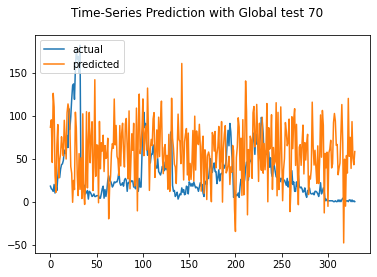

Test MAE: 74.413
Test RMSE: 83.406
Test sMAPE: 117.511
Test R Squared: -6.198
{'mae': 74.41295108072686, 'rmse': 83.40633847679773, 'smape': 117.51110445526442, 'r2': -6.198468590209148}


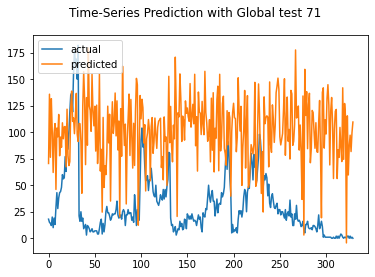

Test MAE: 52.875
Test RMSE: 61.850
Test sMAPE: 107.509
Test R Squared: -2.958
{'mae': 52.87496424624414, 'rmse': 61.84973698584448, 'smape': 107.50869699671271, 'r2': -2.958382117328867}


Test MAE: 60.939
Test RMSE: 69.594
Test sMAPE: 112.238
Test R Squared: -4.012
{'mae': 60.93925850861, 'rmse': 69.59359893128986, 'smape': 112.23782491846609, 'r2': -4.011648386610651}


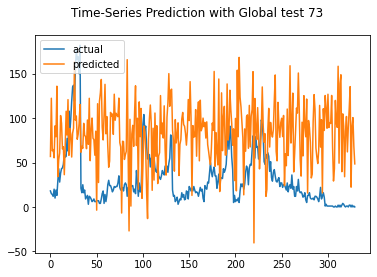

Test MAE: 53.353
Test RMSE: 63.701
Test sMAPE: 106.336
Test R Squared: -3.199
{'mae': 53.35318516781836, 'rmse': 63.70113230176772, 'smape': 106.33606533855333, 'r2': -3.198907484509558}


Test MAE: 49.192
Test RMSE: 57.525
Test sMAPE: 103.854
Test R Squared: -2.424
{'mae': 49.19156952084917, 'rmse': 57.52467366045593, 'smape': 103.85359971097265, 'r2': -2.4241306634393616}


Test MAE: 52.577
Test RMSE: 60.817
Test sMAPE: 105.202
Test R Squared: -2.827
{'mae': 52.576673649296616, 'rmse': 60.817190663541155, 'smape': 105.20243464120445, 'r2': -2.8273194404916753}


Test MAE: 46.540
Test RMSE: 57.568
Test sMAPE: 107.782
Test R Squared: -2.429
{'mae': 46.54042299245343, 'rmse': 57.56845806260579, 'smape': 107.78194014312648, 'r2': -2.429345141364176}


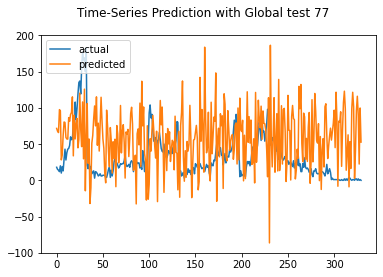

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 39.793
Test RMSE: 50.472
Test sMAPE: 115.121
Test R Squared: -1.636
{'mae': 39.79289949102835, 'rmse': 50.47207924057629, 'smape': 115.1206378845408, 'r2': -1.6359938588532486}


Test MAE: 34.382
Test RMSE: 45.202
Test sMAPE: 124.068
Test R Squared: -1.114
{'mae': 34.382175995544955, 'rmse': 45.20199155356707, 'smape': 124.0678717781917, 'r2': -1.1142539043756687}


Test MAE: 36.874
Test RMSE: 48.385
Test sMAPE: 107.943
Test R Squared: -1.423
{'mae': 36.87389698769107, 'rmse': 48.38546321786176, 'smape': 107.94317197981628, 'r2': -1.4225447482492442}


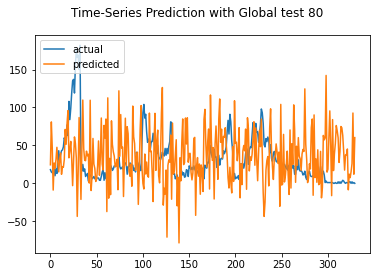

Test MAE: 44.159
Test RMSE: 54.119
Test sMAPE: 101.829
Test R Squared: -2.031
{'mae': 44.159230730930965, 'rmse': 54.11908499348084, 'smape': 101.82926097753, 'r2': -2.030699603550698}


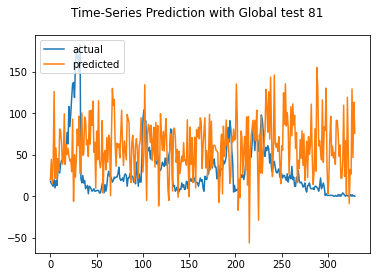

Test MAE: 42.419
Test RMSE: 51.494
Test sMAPE: 100.583
Test R Squared: -1.744
{'mae': 42.41877834507913, 'rmse': 51.49352372984612, 'smape': 100.58294183559234, 'r2': -1.7437669806972007}


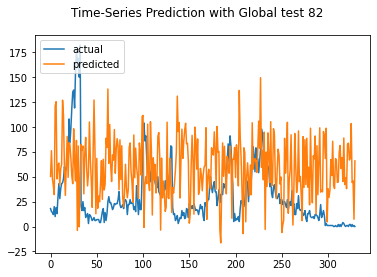

Test MAE: 39.904
Test RMSE: 49.820
Test sMAPE: 104.508
Test R Squared: -1.568
{'mae': 39.904103335106015, 'rmse': 49.81993754770041, 'smape': 104.50763964914323, 'r2': -1.5683154198986542}


Test MAE: 44.592
Test RMSE: 53.780
Test sMAPE: 107.452
Test R Squared: -1.993
{'mae': 44.59161322315534, 'rmse': 53.77986385219258, 'smape': 107.45244734459074, 'r2': -1.9928255205636978}


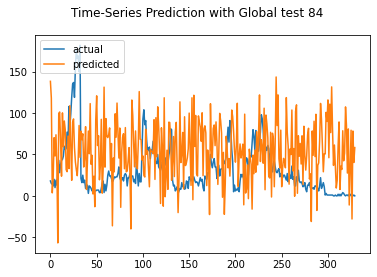

Test MAE: 54.984
Test RMSE: 63.606
Test sMAPE: 106.472
Test R Squared: -3.186
{'mae': 54.98404999537902, 'rmse': 63.605638818360134, 'smape': 106.47217481676705, 'r2': -3.186327872665445}


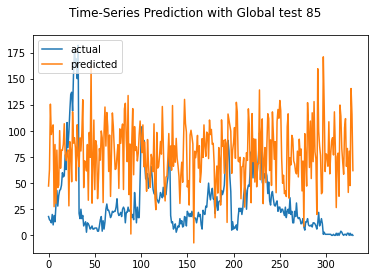

Test MAE: 35.169
Test RMSE: 43.689
Test sMAPE: 100.743
Test R Squared: -0.975
{'mae': 35.16858143978047, 'rmse': 43.68925209877595, 'smape': 100.74296004753992, 'r2': -0.9751097011759144}


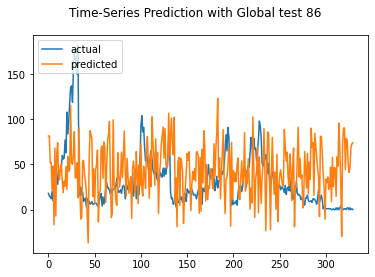

Test MAE: 59.918
Test RMSE: 68.106
Test sMAPE: 110.907
Test R Squared: -3.800
{'mae': 59.91778549064289, 'rmse': 68.1055798342716, 'smape': 110.90686917043213, 'r2': -3.7996259326641493}


Test MAE: 52.505
Test RMSE: 60.215
Test sMAPE: 105.484
Test R Squared: -2.752
{'mae': 52.50472883455681, 'rmse': 60.21527792060983, 'smape': 105.48396026949955, 'r2': -2.751935743805452}


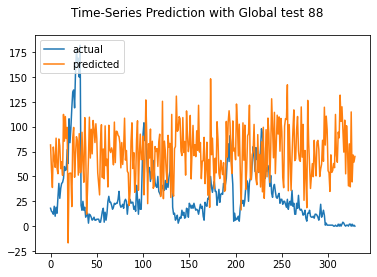

Test MAE: 50.525
Test RMSE: 58.850
Test sMAPE: 104.640
Test R Squared: -2.584
{'mae': 50.52536527604768, 'rmse': 58.85045518999802, 'smape': 104.63954075586986, 'r2': -2.583782581580074}


Test MAE: 36.483
Test RMSE: 45.645
Test sMAPE: 103.072
Test R Squared: -1.156
{'mae': 36.48281626629107, 'rmse': 45.64459372598329, 'smape': 103.07240390408276, 'r2': -1.1558606886084766}


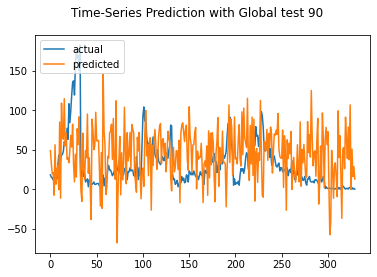

Test MAE: 39.158
Test RMSE: 47.920
Test sMAPE: 100.545
Test R Squared: -1.376
{'mae': 39.15783940463355, 'rmse': 47.9197644152166, 'smape': 100.54548935557166, 'r2': -1.3761363066408507}


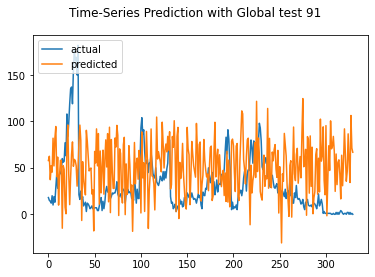

Test MAE: 49.529
Test RMSE: 57.866
Test sMAPE: 103.779
Test R Squared: -2.465
{'mae': 49.52940274874369, 'rmse': 57.865871544105005, 'smape': 103.77867540780238, 'r2': -2.4648704318335484}


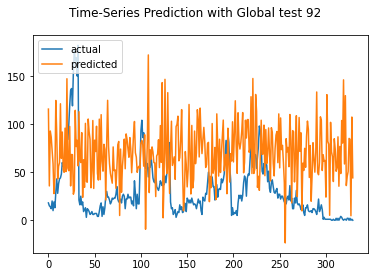

Test MAE: 65.109
Test RMSE: 73.868
Test sMAPE: 112.573
Test R Squared: -4.646
{'mae': 65.1092847737399, 'rmse': 73.86835488743661, 'smape': 112.57262714871952, 'r2': -4.64623377636636}


Test MAE: 37.125
Test RMSE: 45.648
Test sMAPE: 96.220
Test R Squared: -1.156
{'mae': 37.125169017910956, 'rmse': 45.64754347033787, 'smape': 96.21962664161234, 'r2': -1.1561393390621943}


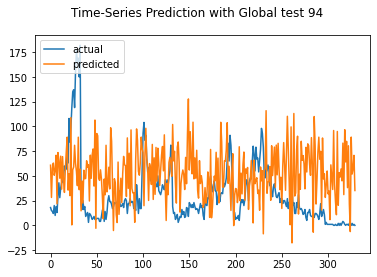

Test MAE: 50.257
Test RMSE: 59.234
Test sMAPE: 104.751
Test R Squared: -2.631
{'mae': 50.25745647170327, 'rmse': 59.23370002115276, 'smape': 104.75064531458459, 'r2': -2.630611047942277}


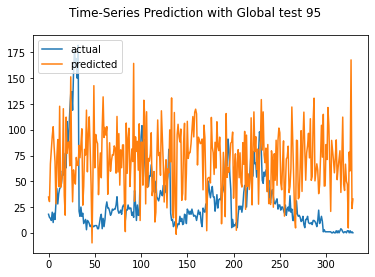

Test MAE: 48.530
Test RMSE: 56.719
Test sMAPE: 102.896
Test R Squared: -2.329
{'mae': 48.52989420168328, 'rmse': 56.719083285470305, 'smape': 102.89640966524581, 'r2': -2.328897382445175}


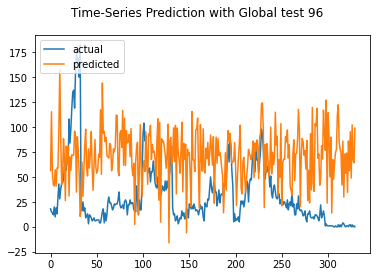

Test MAE: 48.292
Test RMSE: 58.355
Test sMAPE: 103.044
Test R Squared: -2.524
{'mae': 48.292082065885715, 'rmse': 58.354904350323686, 'smape': 103.04410422294009, 'r2': -2.5236821363274355}


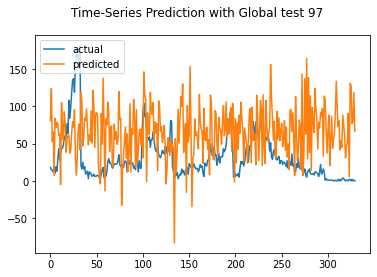

Test MAE: 49.265
Test RMSE: 58.196
Test sMAPE: 101.037
Test R Squared: -2.505
{'mae': 49.26498024319157, 'rmse': 58.19620506655982, 'smape': 101.03695518749637, 'r2': -2.5045425132784707}


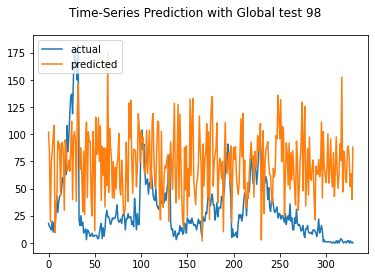

Test MAE: 38.442
Test RMSE: 47.719
Test sMAPE: 93.982
Test R Squared: -1.356
{'mae': 38.44194025054122, 'rmse': 47.71855243269089, 'smape': 93.9819777710062, 'r2': -1.3562237159806707}


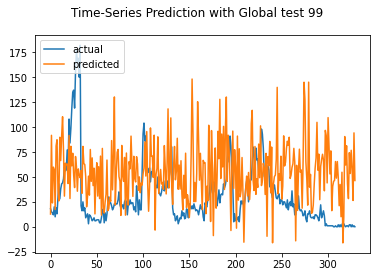

rmse : average=58.446, std=9.885
mae : average=49.336, std=10.118
smape : average=105.900, std=5.667
r2 : average=-2.636, std=1.263


([58.44560557246174, 9.88463401472063],
 [49.33577911838707, 10.118070611999562],
 [105.90025591373153, 5.666531164773771],
 [-2.6357471922211078, 1.2634815103541117])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')